In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from itertools import chain

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            if gamma_dict[num-L].item(i,j) != 0:
                tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
                tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            else:
                tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/(1.0e-9)
                tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/(1.0e-9)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)     

def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

def v_value(x0,x1,x):
    if x != 0:
        return (x0-x1)/x
    else:
        return 0
    
def newton(fun,dfun,a, stepmax, tol):
    if abs(fun(a))<=tol: return a
    for step in range(1, stepmax+1):
        b=a-fun(a)/dfun(a)
        if abs(fun(b))<=tol:
            return b
        else:
            a = b
    return b 

# simplist
def baseline(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    #I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_classic=dict()
    gamma_classic[0]=np.matrix(xi+1.0e-9)
    for repeat in range(K):
        gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
        gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
    return gamma_classic

# our method | total repair
def total_repair(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
    nu=np.zeros(bin)
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in J:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        dfun = lambda z: sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        J=np.where(~((abs(np.matrix(tmp).T @ V).A1)<=1.0e-5))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in J:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
            dfun = lambda z: sum(tmp.item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[K*L])
    return gamma_dict

# our method | partial repair
def partial_repair(C,e,px,ptx,V,theta_scale,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    theta=bbm1*theta_scale
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    Jplus=np.where(~((gamma_dict[2].T @ V).A1 <=theta.A1))[0].tolist()
    Jminus=np.where(~((gamma_dict[2].T @ V).A1>=-theta.A1))[0].tolist()
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in Jplus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    for j in Jminus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        Jplus=np.where(~((np.matrix(tmp).T @ V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((np.matrix(tmp).T @ V).A1>=-theta.A1))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in Jplus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        for j in Jminus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*K])
    return gamma_dict

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def plot_rdist(rdist,x_range):
    plt.plot(x_range,rdist['x'],label=r'$Pr[x]$',color='tab:blue')
    plt.plot(x_range,rdist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
    plt.plot(x_range,rdist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
    plt.ylabel('PMF',fontsize=14)
    plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=20)
    plt.legend()
    return plt

def DisparateImpact(X_test,y_pred):
    dim=X_test.shape[1]-2
    df_test=pd.DataFrame(np.concatenate((X_test,y_pred.reshape(-1,1)), axis=1),columns=[*range(dim)]+['S','W','f'])
    numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==0]['W'])
    denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==1]['W'])
    return numerator/denominator
    
def rdata_analysis(rdata,x_range,x_name):
    rdist=dict()
    pivot=pd.pivot_table(rdata,index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot0=pd.pivot_table(rdata[rdata['S']==0],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot1=pd.pivot_table(rdata[rdata['S']==1],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    rdist['x']= np.array([pivot[i] for i in x_range])/sum([pivot[i] for i in x_range]) #empirical_distribution(rdata,x_range)
    rdist['x_0']=np.array([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range])/sum([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==0],x_range)
    rdist['x_1']=np.array([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range])/sum([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==1],x_range)
    return rdist

def c_generate_higher(x_range,weight):
    bin=len(x_range)
    dim=len(x_range[0])
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=sum(weight[d]*abs(x_range[i][d]-x_range[j][d]) for d in range(dim))
    return C

def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j]) 
    return C

def projection(df,coupling_matrix,x_range,x_name,var_list):
    bin=len(x_range)
    var_list_tmp=var_list[:]
    var_list_tmp.remove(x_name)
    var_list_tmp=[x_name]+var_list_tmp # place the var that needs to be repaired the first
    df=df[var_list_tmp+['S','W','Y']]
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=var_list_tmp+['S','W','Y'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where([x_range[i]==orig[x_name] for i in range(bin)])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub_dict={x_name:[x_range[r] for r in rows],'W':list(coupling[loc,rows]/(sum(coupling[loc,rows]))*orig['W'])}
        sub_dict.update({var:[orig[var]]*len(rows) for var in var_list_tmp[1:]+['S','Y']})
        sub=pd.DataFrame(data=sub_dict, index=rows)
        df_t=pd.concat([df_t,sub],ignore_index=True)#pd.concat([df_t,samples_groupby(sub,x_list)], ignore_index=True)
    df_t=df_t.groupby(by=list(chain(*[var_list,'S','Y'])),as_index=False).sum()
    df_t=df_t[var_list+['S','W','Y']]
    return df_t

In [266]:
pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv').head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [22]:
K=150
e=0.01
var_list=['age','education-num','capitalgain','capitalloss','hoursperweek']
var_dim=len(var_list)
messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=var_list+['race','class'])
#S=1: White S=0: Black
messydata=messydata[(messydata['race']=='White')|(messydata['race']=='Black')]
messydata['race']=messydata['race'].replace('White',1)
messydata['race']=messydata['race'].replace('Black',0)
messydata['class']=messydata['class'].replace('>50K',1)
messydata['class']=messydata['class'].replace('<=50K',0)
for col in ['race','class']+var_list:
    messydata[col]=messydata[col].astype('category')
#cat_columns = messydata.select_dtypes(['category']).columns
#messydata[cat_columns]=messydata[cat_columns].apply(lambda x: x.cat.codes)
messydata=messydata.rename(columns={'race':'S','class':'Y'}) #'education-num':'X1','hoursperweek':'X2',
messydata['W']=1

tv_dist=dict()
for x_name in var_list:
    x_range=list(pd.pivot_table(messydata,index=x_name,values=['W'])[('W')].index) 
    dist=rdata_analysis(messydata,x_range,x_name)
    tv_dist[x_name]=sum(abs(dist['x_0']-dist['x_1']))/2

In [3]:
tv_dist

{'age': 0.04149230147335384,
 'education-num': 0.11867963282506956,
 'capitalgain': 0.026764553949230142,
 'capitalloss': 0.014217783478743178,
 'hoursperweek': 0.12216173195089294}

In [271]:
x_list=['education-num','hoursperweek']
X=messydata[list(chain(*[var_list,'S','W']))].to_numpy()
y=messydata['Y'].to_numpy()

report=pd.DataFrame(columns=['DI','f1 macro','f1 micro','f1 weighted','method'])

for igonre in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=list(chain(*[var_list,'S','W','Y'])))
    df=df.groupby(by=list(chain(*[var_list,'S','Y'])),as_index=False).sum()
    df=df[var_list+['S','W','Y']]

    rdata_base=df
    rdata_part=df
    for x_name in x_list:
        x_range=list(pd.pivot_table(df,index=x_name,values=['W'])[('W')].index) #[(i,j) for i in x_range_full[x_list[0]] for j in x_range_full[x_list[1]]]
        bin=len(x_range)
        dist=rdata_analysis(df,x_range,x_name)

        C=c_generate(x_range)
        dist['t_x']=dist['x_0']*0.5+dist['x_1']*0.5
        dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]
        px=np.matrix(dist['x']).T
        ptx=np.matrix(dist['t_x']).T
        V=np.matrix(dist['v']).T

        rdata_base=projection(rdata_base,baseline(C,e,px,ptx,V,K)[K*2],x_range,x_name,var_list)
        rdata_part2=projection(rdata_part,partial_repair(C,e,px,ptx,V,1.0e-3,K)[K*3],x_range,x_name,var_list)

    X_train_orig=df[var_list+['S','W']].to_numpy()
    y_train_orig=df['Y'].to_numpy().astype('int8')
    clf=RandomForestClassifier(max_depth=3, random_state=0).fit(X_train_orig[:,0:var_dim],y_train_orig,sample_weight=X_train_orig[:,var_dim+1])
    y_pred_orig=clf.predict(X_test[:,0:var_dim])
    new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred_orig),
                        'f1 macro':f1_score(y_test, y_pred_orig, average='macro'),
                        'f1 micro':f1_score(y_test, y_pred_orig, average='micro'),
                        'f1 weighted':f1_score(y_test, y_pred_orig, average='weighted'),
                        'method':'origin'})
    #print(new_row)
    X_train_base=rdata_base[var_list+['S','W']].to_numpy()
    y_train_base=rdata_base['Y'].to_numpy().astype('int8')
    clf_base=RandomForestClassifier(max_depth=3, random_state=0).fit(X_train_base[:,0:var_dim],y_train_base,sample_weight=X_train_base[:,var_dim+1])
    y_pred_base=clf_base.predict(X_test[:,0:var_dim])
    new_row_base = pd.Series({'DI':DisparateImpact(X_test,y_pred_base),
                    'f1 macro':f1_score(y_test, y_pred_base, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_base, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_base, average='weighted'),
                    'method':'baseline'})
    #print(new_row_base)
    X_train_part=rdata_part2[var_list+['S','W']].to_numpy()
    y_train_part=rdata_part2['Y'].to_numpy().astype('int8')
    clf_part= RandomForestClassifier(max_depth=3, random_state=0).fit(X_train_part[:,0:var_dim],y_train_part,sample_weight=X_train_part[:,var_dim+1])
    y_pred_part=clf_part.predict(X_test[:,0:var_dim])
    new_row_part = pd.Series({'DI':DisparateImpact(X_test,y_pred_part),
                    'f1 macro':f1_score(y_test, y_pred_part, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_part, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_part, average='weighted'),
                    'method':'partial repair'})
    #print(new_row_part)
    report = pd.concat([report,new_row.to_frame().T,new_row_base.to_frame().T,new_row_part.to_frame().T], ignore_index=True)

sum of violation of f: 0.006147738739427774
sum of violation of g: 1.0364972768961422e-16
total cost: 0.26267604891567553
entropy: 2.1685705657507257
tr violation: [[0.19512933]]
sum of violation of f: 0.004664660498218499
sum of violation of g: 9.44097655945172e-05
total cost: 1.5302919160219526
entropy: 2.7302133015381487
tr violation: [[0.01516359]]
sum of violation of f: 0.007466593399421045
sum of violation of g: 1.942890293094024e-16
total cost: 0.061606181817546526
entropy: 1.3443085023648327
tr violation: [[0.19937852]]
sum of violation of f: 0.0030300898363515433
sum of violation of g: 6.543646764484157e-05
total cost: 0.5471139025423968
entropy: 1.9361671038446628
tr violation: [[0.00499335]]
DI             0.423402
f1 macro       0.665225
f1 micro       0.817008
f1 weighted     0.78514
method           origin
dtype: object
DI             0.464979
f1 macro       0.646516
f1 micro       0.815716
f1 weighted    0.776614
method         baseline
dtype: object
DI                  

In [275]:
report

,DI,f1 macro,f1 micro,f1 weighted,method
0,0.423402,0.665225,0.817008,0.78514,origin
1,0.464979,0.646516,0.815716,0.776614,baseline
2,0.479121,0.636445,0.814496,0.771791,partial repair
3,0.505911,0.658364,0.80854,0.77434,origin
4,0.526156,0.647522,0.80897,0.769665,baseline
5,0.592169,0.658882,0.809903,0.775096,partial repair
6,0.457081,0.625355,0.801794,0.755189,origin
7,0.449907,0.627952,0.802655,0.756697,baseline
8,0.473609,0.643559,0.806961,0.765431,partial repair


In [265]:
print(new_row)
print(new_row_base)
print(new_row_part)

DI             0.405241
f1 macro       0.631541
f1 micro       0.810405
f1 weighted    0.765712
method           origin
dtype: object
DI             0.420241
f1 macro        0.64352
f1 micro       0.812917
f1 weighted    0.771952
method         baseline
dtype: object
DI                   0.453653
f1 macro             0.631035
f1 micro             0.810477
f1 weighted          0.765515
method         partial repair
dtype: object


In [ ]:
print(new_row)
print(new_row_base)
print(new_row_part)

DI             0.426499
f1 macro         0.6465
f1 micro       0.811625
f1 weighted    0.771627
method           origin
dtype: object
DI             0.436256
f1 macro       0.631836
f1 micro       0.808611
f1 weighted     0.76396
method         baseline
dtype: object
DI                   0.441127
f1 macro             0.639745
f1 micro             0.809975
f1 weighted          0.767999
method         partial repair
dtype: object


In [51]:
report=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/report_higher_rw.csv')
performance=list(report.columns)[:-2]
#methods=['origin','baseline','partial repair']
methods=['origin','baseline','partial_repair2','partial_repair3','partial_repair4'] #,'partial_repair4'
test=['origin','re-weighted']
#list(set(report['method']))
colors=['#5f0f40','#9a031e','#FF8811','#F4D06F','#9DD9D2']
pivot=pd.pivot_table(report,index=['method','test set'],values=performance,aggfunc=[np.mean,np.std])
pivot

mean                                  \
                                   DI  f1 macro  f1 micro f1 weighted   
method          test set                                                
baseline        origin       0.451023  0.693249  0.819615    0.795627   
                re-weighted  0.451767  0.698229  0.855894    0.835053   
origin          origin       0.437015  0.640696  0.810673    0.769197   
                re-weighted  0.437529  0.651446  0.852033    0.817312   
partial_repair2 origin       0.552321  0.630550  0.807999    0.763705   
                re-weighted  0.553995  0.644827  0.849514    0.813971   
partial_repair3 origin       0.562742  0.630758  0.807590    0.763649   
                re-weighted  0.563548  0.644347  0.848723    0.813482   
partial_repair4 origin       0.565755  0.630714  0.807492    0.763593   
                re-weighted  0.565943  0.644173  0.848545    0.813347   

                                  std                                  
                                   DI  f1 macro  f1 micro f1 weighted  
method          test set                                               
baseline        origin       0.041175  0.006409  0.003221    0.004475  
                re-weighted  0.046254  0.008147  0.003859    0.004767  
origin          origin       0.053047  0.011816  0.003646    0.006984  
                re-weighted  0.059095  0.011376  0.003295    0.005376  
partial_repair2 origin       0.064981  0.007243  0.002895    0.004679  
                re-weighted  0.066206  0.007772  0.002958    0.004090  
partial_repair3 origin       0.066177  0.005460  0.002669    0.003779  
                re-weighted  0.066913  0.006808  0.002823    0.003592  
partial_repair4 origin       0.066381  0.005875  0.002681    0.003922  
                re-weighted  0.066907  0.007387  0.002914    0.003808

In [25]:
pivot[('mean','DI')][('origin','origin')]

0.4153894155484112

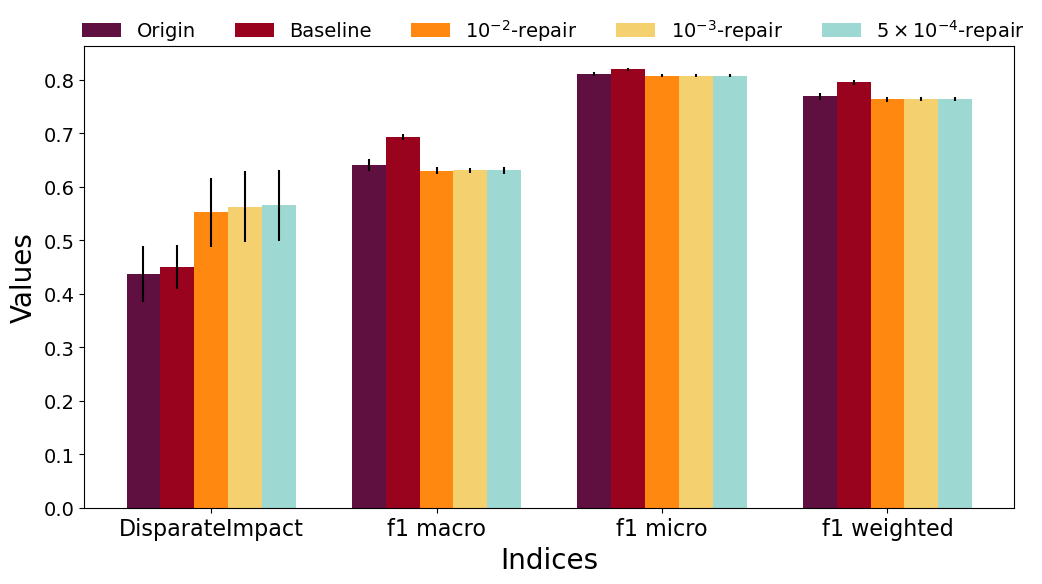

In [53]:
ind=np.arange(len(performance))
width = 0.15

fig, ax1 = plt.subplots(figsize=(12,6))

# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(['Colours'] + handles[:4] + ['Symbols'] + handles[:1]+ handles[4:5]+[' '],
#           [''] + labels[:4] + [''] + ['Original','Reweighted']+[' '],
#            handler_map={str: LegendTitle({'fontsize': 18})},
#           bbox_to_anchor=(0.75,1.4), fontsize=16,frameon=False,ncol=2
#         )

i=0
for m in methods:
    sub=[pivot[('mean',p)][(m,'origin')] for p in performance]
    sub1=[pivot[('mean',p)][(m,'re-weighted')] for p in performance]
    err=[pivot[('std',p)][(m,'origin')] for p in performance]
    err1=[pivot[('std',p)][(m,'re-weighted')] for p in performance]
    ax1.bar(ind+width*i,sub,width,yerr=err,color=colors[i],label=m) #,yerr=err
    #ax1.bar(ind+width*i,sub1,width,yerr=err1,color=colors[i],label=m)
    #ax1.scatter(ind+width*i,sub1, marker='o',s=50,color=colors[i],label=m)
    i+=1

ax1.legend(['Origin','Baseline',r'$10^{-2}$-repair',r'$10^{-3}$-repair',r'$5\times 10^{-4}$-repair'],fontsize=14,
            framealpha=0.2,bbox_to_anchor=(1.03,1.1),ncol=5,frameon=False)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width*2)
ax1.set_xticklabels(['DisparateImpact']+[i for i in performance[1:]], fontsize=16)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#plt.savefig("C:/Users/zhouq/Documents/optimal_transport/adult_higher.pdf",bbox_inches='tight')

In [56]:
report=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/report_education-num.csv')
performance=list(report.columns)[:-1]
#methods=['origin','baseline','partial repair']
methods=['origin','baseline','partial_repair2','partial_repair3','partial_repair4']
#list(set(report['method']))
colors=['#5f0f40','#9a031e','#FF8811','#F4D06F','#9DD9D2']
pivot=pd.pivot_table(report,index=['method'],values=performance,aggfunc=[np.mean,np.std])
pivot

mean                                       std            \
                       DI  f1 macro  f1 micro f1 weighted        DI  f1 macro   
method                                                                          
baseline         0.457089  0.637040  0.809621    0.766769  0.046052  0.012036   
origin           0.458575  0.636046  0.809496    0.766291  0.051417  0.008977   
partial_repair2  0.531885  0.593479  0.799770    0.743597  0.071057  0.006627   
partial_repair3  0.542128  0.598456  0.800545    0.746132  0.065052  0.007334   
partial_repair4  0.545265  0.599053  0.800636    0.746434  0.067692  0.007503   

                                       
                 f1 micro f1 weighted  
method                                 
baseline         0.002977    0.006701  
origin           0.002435    0.005074  
partial_repair2  0.002604    0.004510  
partial_repair3  0.002380    0.004234  
partial_repair4  0.002341    0.004283

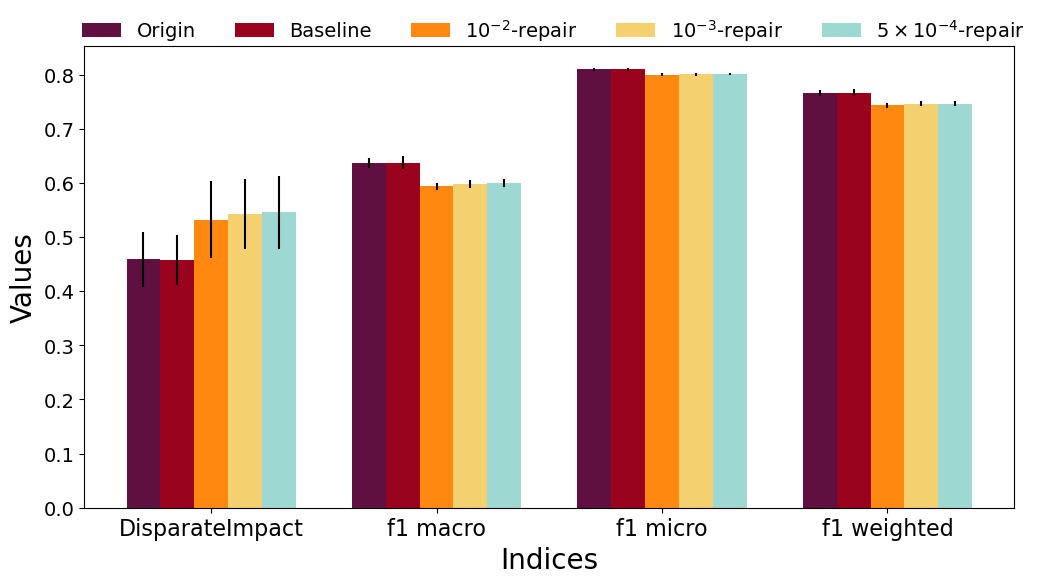

In [57]:
ind=np.arange(len(performance))
width = 0.15

fig, ax1 = plt.subplots(figsize=(12,6))

i=0
for m in methods:
    sub=[pivot[('mean',p)][m] for p in performance]
    err=[pivot[('std',p)][m] for p in performance]
    ax1.bar(ind+width*i,sub,width,yerr=err,color=colors[i],label=m)
    i+=1
    
ax1.legend(['Origin','Baseline',r'$10^{-2}$-repair',r'$10^{-3}$-repair',r'$5\times 10^{-4}$-repair'],fontsize=14,
            framealpha=0.2,bbox_to_anchor=(1.03,1.1),ncol=5,frameon=False)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width*2)
ax1.set_xticklabels(['DisparateImpact']+[i for i in performance[1:]], fontsize=16)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#plt.savefig("C:/Users/zhouq/Documents/optimal_transport/adult_education.pdf",bbox_inches='tight')

In [86]:
weight=[1]
x_list=['education-num'] #'education-num','capitalgain','capitalloss'
dim=len(x_list)
messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=x_list+['race','class'])
messydata=messydata[(messydata['race']=='White')|(messydata['race']=='Black')]
for col in ['race','class']+x_list:
    messydata[col]=messydata[col].astype('category')
cat_columns = messydata.select_dtypes(['category']).columns
messydata[cat_columns]=messydata[cat_columns].apply(lambda x: x.cat.codes)
messydata=messydata.rename(columns={'race':'S','class':'Y'}) #'education-num':'X1','hoursperweek':'X2',
messydata['W']=1
#x_range_full=dict()
#for name in x_list:
#    x_range_full[name]=np.arange(min(df[name]),max(df[name])+1,1)
X=messydata[list(chain(*[x_list,'S','W']))].to_numpy()
y=messydata['Y'].to_numpy()
e=0.01
K=200
report=pd.DataFrame(columns=['DI','f1 macro','f1 micro','f1 weighted','method'])
for ignore in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=list(chain(*[x_list,'S','W','Y'])))
    df=df.groupby(by=list(chain(*[x_list,'S','Y'])),as_index=False).sum()
    df=df[x_list+['S','W','Y']]
    x_range=list(pd.pivot_table(df,index=list(chain(*[x_list])),values=['W'],aggfunc=[np.sum])[('sum','W')].index) #[(i,j) for i in x_range_full[x_list[0]] for j in x_range_full[x_list[1]]]
    dist=rdata_analysis(df,x_range)
    bin=len(x_range)
    if dim>1:
        C=c_generate_higher(x_range,weight)
    else:
        C=c_generate(x_range)
    dist['t_x']=dist['x_0']*0.5+dist['x_1']*0.5
    dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]
    px=np.matrix(dist['x']).T
    ptx=np.matrix(dist['t_x']).T
    V=np.matrix(dist['v']).T

    rdata_base=projection(df,baseline(C,e,px,ptx,V,K)[K*2],x_range,x_list)
    rdata_part2=projection(df,partial_repair(C,e,px,ptx,V,1.0e-2,K)[K*3],x_range,x_list)

    X_train=df[x_list+['S','W']].to_numpy()
    y_train=df['Y'].to_numpy().astype('int8')
    clf=RandomForestClassifier(max_depth=3).fit(X_train[:,0:dim],y_train,sample_weight=X_train[:,dim+1])
    y_pred=clf.predict(X_test[:,0:dim])
    new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred),
                        'f1 macro':f1_score(y_test, y_pred, average='macro'),
                        'f1 micro':f1_score(y_test, y_pred, average='micro'),
                        'f1 weighted':f1_score(y_test, y_pred, average='weighted'),
                        'method':'origin'})
    X_train_base=rdata_base[x_list+['S','W']].to_numpy()
    y_train_base=rdata_base['Y'].to_numpy().astype('int8')
    clf_base=RandomForestClassifier(max_depth=3, random_state=0).fit(X_train_base[:,0:dim],y_train_base,sample_weight=X_train_base[:,dim+1])
    y_pred_base=clf_base.predict(X_test[:,0:dim])
    new_row_base = pd.Series({'DI':DisparateImpact(X_test,y_pred_base),
                    'f1 macro':f1_score(y_test, y_pred_base, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_base, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_base, average='weighted'),
                    'method':'baseline'})
    X_train_part=rdata_part2[x_list+['S','W']].to_numpy()
    y_train_part=rdata_part2['Y'].to_numpy().astype('int8')
    clf_part= RandomForestClassifier(max_depth=3, random_state=0).fit(X_train_part[:,0:dim],y_train_part,sample_weight=X_train_part[:,dim+1])
    y_pred_part=clf_part.predict(X_test[:,0:dim])
    new_row_part = pd.Series({'DI':DisparateImpact(X_test,y_pred_part),
                    'f1 macro':f1_score(y_test, y_pred_part, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_part, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_part, average='weighted'),
                    'method':'partial repair'})
    report = pd.concat([report,new_row.to_frame().T,new_row_base.to_frame().T,new_row_part.to_frame().T], ignore_index=True)

sum of violation of f: 0.0053423887300277405
sum of violation of g: 1.1405806854547507e-16
total cost: 0.26000881230054806
entropy: 2.1782510196307476
tr violation: [[0.19454073]]
sum of violation of f: 0.00667936069408783
sum of violation of g: 1.4498721551707214e-06
total cost: 0.9820000335606361
entropy: 2.5381214804629093
tr violation: [[0.0909923]]
sum of violation of f: 0.005165601578017062
sum of violation of g: 2.688821387764051e-17
total cost: 0.25485684827426264
entropy: 2.1699138015902792
tr violation: [[0.19330643]]
sum of violation of f: 0.006346419203197311
sum of violation of g: 7.018484796829155e-05
total cost: 1.03385732565281
entropy: 2.5098864428933663
tr violation: [[0.08652732]]
sum of violation of f: 0.004181146350499369
sum of violation of g: 1.2576745200831851e-16
total cost: 0.27367338122199975
entropy: 2.200215134935635
tr violation: [[0.20606489]]
sum of violation of f: 0.0021119083119694724
sum of violation of g: 0.00014591962594249532
total cost: 0.96596328